# SQL & 探索的データ解析

この演習では，食料品即日配達サービス[Instacart](https://www.instacart.com)の注文データを用いる．演習を開始する前に，[データダウンロードリンク](https://www.instacart.com/datasets/grocery-shopping-2017)よりデータが納められたzipファイル（約200MB）をダウンロードしておくこと．

ダウンロードしたzipファイルには下記6つのcsvファイルが圧縮されている．
* ``departments.csv``: 商品売り場（カテゴリ）に関するデータ（21件）
* ``aisles.csv``: 商品棚（サブカテゴリ）に関するデータ（134件）
* ``products.csv``: 商品に関するデータ（約5万件）
* ``orders.csv``: 注文に関するデータ（約20万6000ユーザによる約340万件の注文）
* ``order_products__train.csv``: 各Instacartユーザが最も最近行った注文の明細データ
* ``order_products__prior.csv``: 各Instacartユーザが過去に行った注文の明細データ（最も最近の注文を除く）

各csvファイルの詳細は，``data/instacart``ディレクトリの``data-recipe.md``ファイルで確認することができる．

### Q1. データベース作成
ダウンロードしたcsvファイル内のデータをSQLiteのデータベースに格納せよ．テーブル名は``department``のように，csvファイル名から拡張子を取り除いたものにせよ．ただし，``order_products__train.csv``と``order_products__prior.csv``のデータについては，``order_products``というテーブルを作成し，そこにデータを格納せよ．カラム情報は``data/instacart``ディレクトリの``data-recipe.md``ファイルに記した内容に従うこと．

なお，必要であれば，``data/instacart``ディレクトリの``init_sqlite.sql``ファイルを利用してもよい．

In [1]:
import sqlite3
import pandas as pd
import pandas.io.sql as psql
from os.path import join, split
from glob import glob
import csv


In [18]:
# DB作成
db_path = '../instacart.db'

# 接続
con = sqlite3.connect(db_path)
#cur = con.cursor() # sqliteを操作するカーソルオブジェクトを作成
con.close() # 接続を閉じる（必須）

In [19]:
# テーブル作成
con = sqlite3.connect(db_path)
cur = con.cursor()

cur.execute(
    '''
    CREATE TABLE IF NOT EXISTS departments(
        department_id INTEGER PRIMARY KEY,
        department VARCHAR(128)
    )
    '''
)

cur.execute(
    '''
    CREATE TABLE IF NOT EXISTS aisles(
        aisle_id INTEGER PRIMARY KEY, 
        aisle TEXT
    )
    '''
)

cur.execute(
    '''
    CREATE TABLE IF NOT EXISTS products(
        product_id INTEGER PRIMARY KEY, 
        product_name TEXT, 
        aisle_id INTEGER, 
        department_id INTEGER,
        foreign key (aisle_id) references aisles(aisle_id),
        foreign key (department_id) references departments(department_id)
    )
    '''
)


cur.execute(
    '''
    CREATE TABLE IF NOT EXISTS products(
        product_id INTEGER PRIMARY KEY, 
        product_name TEXT, 
        aisle_id INTEGER,
        department_id INTEGER,
        foreign key (aisle_id) references aisles(aisle_id),
        foreign key (department_id) references departments(department_id)
    )
    '''
)

cur.execute(
    '''
    CREATE TABLE IF NOT EXISTS orders(
    order_id INTEGER PRIMARY KEY, 
    user_id INTEGER, 
    eval_set TEXT,
    order_number INTEGER,
    order_dow INTEGER,
    order_hour_of_day TEXT,
    days_since_prior INTEGER
    )
    '''
)

cur.execute(
    '''
    CREATE TABLE IF NOT EXISTS order_products(
        order_id int  NOT NULL,
        product_id int  NOT NULL,
        add_to_cart_order int,
        reordered int,
        foreign key (order_id) references orders(order_id),
        foreign key (product_id) references products(product_id)
    )
    '''
)

con.commit()
con.close()

In [13]:
# 下のセルを複数回実行すると同じデータが追加されるため，その場合はテーブルのデータを削除する
""" con = sqlite3.connect(db_path)
cur = con.cursor()
delete_data = 'DELETE FROM departments'
cur.execute(delete_data)
con.commit() # 変更をコミット
con.close() """

In [20]:
# コマンド(sqlite3)によるCSVのインポート時に，既にテーブルがある場合はCSVのヘッダーを無視できない
# よって事前にheader
csv_path = '../data/instacart_2017_05_01'

con = sqlite3.connect(db_path)
cur = con.cursor()

# departments
open_csv = open(glob(join(csv_path, 'departments.csv'))[0])
read_csv = csv.reader(open_csv)

next_row = next(read_csv)

rows = []
for row in read_csv:
    rows.append(row)

cur.executemany(
    'INSERT INTO departments (department_id, department) VALUES (?, ?)', rows
)

con.commit()
open_csv.close()

# aisles
open_csv = open(glob(join(csv_path, 'aisles.csv'))[0])
read_csv = csv.reader(open_csv)

next_row = next(read_csv)

rows = []
for row in read_csv:
    rows.append(row)

cur.executemany(
    'INSERT INTO aisles (aisle_id, aisle) VALUES (?, ?)', rows
)

con.commit()
open_csv.close()

# products
open_csv = open(glob(join(csv_path, 'products.csv'))[0])
read_csv = csv.reader(open_csv)

next_row = next(read_csv)

rows = []
for row in read_csv:
    rows.append(row)

cur.executemany(
    '''
    INSERT INTO products (
        product_id,
        product_name,
        aisle_id,
        department_id
    )
    VALUES (?, ?, ?, ?)
    ''',
    rows
)

con.commit()
open_csv.close()

# orders
open_csv = open(glob(join(csv_path, 'orders.csv'))[0])
read_csv = csv.reader(open_csv)

next_row = next(read_csv)

rows = []
for row in read_csv:
    rows.append(row)

cur.executemany(
    '''
    INSERT INTO orders (
        order_id,
        user_id,
        eval_set,
        order_number,
        order_dow,
        order_hour_of_day,
        days_since_prior
    )
    VALUES (?, ?, ?, ?, ?, ?, ?)
    ''',
    rows
)

con.commit()
open_csv.close()

# order_products__train
open_csv = open(glob(join(csv_path, 'order_products__train.csv'))[0])
read_csv = csv.reader(open_csv)

next_row = next(read_csv)

rows = []
for row in read_csv:
    rows.append(row)

cur.executemany(
    '''
    INSERT INTO order_products (
        order_id,
        product_id,
        add_to_cart_order,
        reordered
    )
    VALUES (?, ?, ?, ?)
    ''',
    rows
)

con.commit()
open_csv.close()

# order_products__prior
open_csv = open(glob(join(csv_path, 'order_products__prior.csv'))[0])
read_csv = csv.reader(open_csv)

next_row = next(read_csv)

rows = []
for row in read_csv:
    rows.append(row)

cur.executemany(
    '''
    INSERT INTO order_products (
        order_id,
        product_id,
        add_to_cart_order,
        reordered
    )
    VALUES (?, ?, ?, ?)
    ''',
    rows
)

con.commit()
open_csv.close()

con.close()

In [ ]:
# コマンド(sqlite3)によるCSVのインポート
# 事前に定義したテーブルにインポートする場合，ヘッダーは取り除くことが不可
'''
sqlite3 instacart.db # 接続
sqlite> .mode csv
sqlite> .import data/instacart_2017_05_01/aisles.csv aisles
sqlite> .import data/instacart_2017_05_01/departments.csv departments
sqlite> .import data/instacart_2017_05_01/products.csv products
sqlite> .import data/instacart_2017_05_01/orders.csv orders
sqlite> .import data/instacart_2017_05_01/order_products__train.csv order_products
sqlite> .import data/instacart_2017_05_01/aorder_products__prior.csv order_products

'''

### Q2. pandasデータフレームへの読み込み
``pandas``ライブラリの``read_sql``関数を用いると，SQLite上にあるデータベースにSQLを発行し，その結果を``pandas.DataFrame``データフレームに読み出すことができる．下記コードは，SQLite上にある``instacart``データベースの``department``テーブルの内容をデータフレームに読み込む例である．

``products``テーブル，``aisles``テーブル，``departments``テーブル，``orders``テーブル，``order_products``テーブルのレコード数を調べるSQL文を発行し，各テーブルのレコード数を表示せよ．

In [27]:
db = sqlite3.connect('../instacart.db') # DBと接続する
sql = "SELECT * FROM departments;"
df = psql.read_sql(sql, db)
db.close() # DBとの接続を閉じる（閉じないと開きっぱなしになるので注意）

# 最初の5件を表示
#df.head()
df.shape

(21, 2)

In [37]:
db = sqlite3.connect('../instacart.db') # DBと接続する

sql = "SELECT COUNT(*) as records FROM departments;"
df = psql.read_sql(sql, db)
print('departments: ', df.records.values[0])

sql = "SELECT COUNT(*) as records FROM aisles;"
df = psql.read_sql(sql, db)
print('aisles: ', df.records.values[0])

sql = "SELECT COUNT(*) as records FROM products;"
df = psql.read_sql(sql, db)
print('products: ', df.records.values[0])

sql = "SELECT COUNT(*) as records FROM orders;"
df = psql.read_sql(sql, db)
print('orders:', df.records.values[0])

sql = "SELECT COUNT(*) as records FROM order_products;"
df = psql.read_sql(sql, db)
print('order_products:', df.records.values[0])


db.close()

departments:  21
aisles:  134
products:  49688
orders: 3421083
order_products: 33819106


### Q3. マスターデータ作成（テーブル結合 & 集約演算）
商品部門別および商品棚別に商品数を求めるSQL文を発行し，その結果をデータフレーム形式で表示せよ．なお，表示するデータフレームは下記の形式とせよ（ALLは特定のdepartmentにある全aisleを意味する）．また表示する結果は，商品数の降順でソートしたものとせよ．

| |department |aisle |iterm_count|
|---: |---:|---:|---:|
|0 |personal care |ALL |6563 |
|1 |snacks |ALL |6264 |
|... |... |... |... |
|... |personal care |vitamins supplements |1038 |
|...|personal care |hair care |816 |
|... |... |... |... |

In [43]:
con = sqlite3.connect(db_path)
con = sqlite3.connect(db_path)
sql = '''
    SELECT
        d.department,
        a.aisle,
        COUNT(*) AS item_count 
    FROM
        products p
    JOIN
        departments d
    USING
        (department_id)
    JOIN
        aisles a
    USING
        (aisle_id)
    GROUP BY
        d.department_id,
        a.aisle_id
    UNION ALL
    SELECT
        d.department,
        'ALL' AS aisle,
        COUNT(*) AS item_count 
    FROM
        products p
    JOIN
        departments d
    USING
        (department_id)
    GROUP BY
        d.department_id
    ORDER BY
        item_count DESC
    ;
    '''
df = psql.read_sql(sql, con)
con.close()
df.head(20)

,department,aisle,item_count
0,personal care,ALL,6563
1,snacks,ALL,6264
2,pantry,ALL,5371
3,beverages,ALL,4365
4,frozen,ALL,4007
5,dairy eggs,ALL,3449
6,household,ALL,3085
7,canned goods,ALL,2092
8,dry goods pasta,ALL,1858
9,produce,ALL,1684


### Q4. 注文行動に関する基礎情報（集約演算2）
ユーザID毎に注文回数（``order_frequency``）および注文の平均間隔（``avg_order_interval``）を把握したい．注文回数が10回以上99以下のユーザに関して，ユーザID毎の注文回数と注文平均間隔を求めるSQL文を発行し，注文平均間隔の上位10件（昇順）のユーザ情報のみ表示せよ．結果はデータフレーム形式で表示せよ．なお，ある注文が初回注文だった場合，前回の注文からの経過日数間隔はゼロと考えよ．

In [45]:
con = sqlite3.connect(db_path)
sql = """ 
    SELECT
        user_id,
        MAX(order_number) AS order_freq,
        AVG(days_since_prior) AS avg_order_interval
    FROM
        orders
    GROUP BY
        user_id
    HAVING
        order_freq BETWEEN 10 AND 99
    ORDER BY
        avg_order_interval ASC
    ;
"""
df = psql.read_sql(sql, con)
con.close()
df.head(10)

,user_id,order_freq,avg_order_interval
0,88589,27,0.518519
1,58157,48,0.604167
2,31834,11,0.818182
3,204214,23,0.826087
4,190812,16,0.875000
5,309,26,0.961538
6,15963,10,1.000000
7,68345,10,1.000000
8,175931,42,1.000000
9,192717,10,1.000000


### Q5. 注文タイミング（ヒートマップによる可視化）
注文があった曜日および時間帯別（例: 土曜日の23時）の注文総数を集計するSQL文を発行し，その結果をヒートマップ形式で表示せよ．

In [53]:
con = sqlite3.connect(db_path)
sql = """ 
    SELECT
        order_dow as day,
        order_hour_of_day as hour,
        COUNT(order_id) as order_num
    FROM
        orders
    GROUP BY
        order_dow,
        order_hour_of_day
"""
df = psql.read_sql(sql, con)
con.close()
df.head()

,day,hour,order_num
0,0,00,3936
1,0,01,2398
2,0,02,1409
3,0,03,963
4,0,04,813


### ヒートマップ描写
seaborn.heatmap()で描写できる．
渡すデータは，x軸に設定する変数はindex, y軸に設定する変数はcolumnに持つPivot形式に変換する必要がある．

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

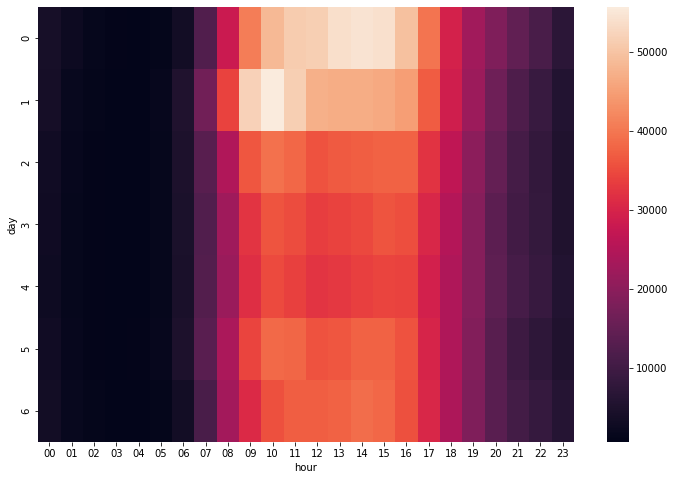

In [59]:
# ヒートマップの作成
df_pivot = pd.pivot_table(
    data=df,
    values='order_num',
    columns='hour',
    index='day'
)
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot)
plt.show()

### Q6. 注文間隔（棒グラフによる可視化）
前回の注文からの経過日数別に注文数を集計するSQL文を発行し，その結果を棒グラフで示せ．

In [62]:
con = sqlite3.connect(db_path)
sql = """  
    SELECT
        days_since_prior as interval,
        COUNT(order_id) as order_num
    FROM
        orders
    GROUP BY
        interval
"""
df = psql.read_sql(sql, con)
con.close()
df.head()

,interval,order_num
0,0,67755
1,1,145247
2,2,193206
3,3,217005
4,4,221696


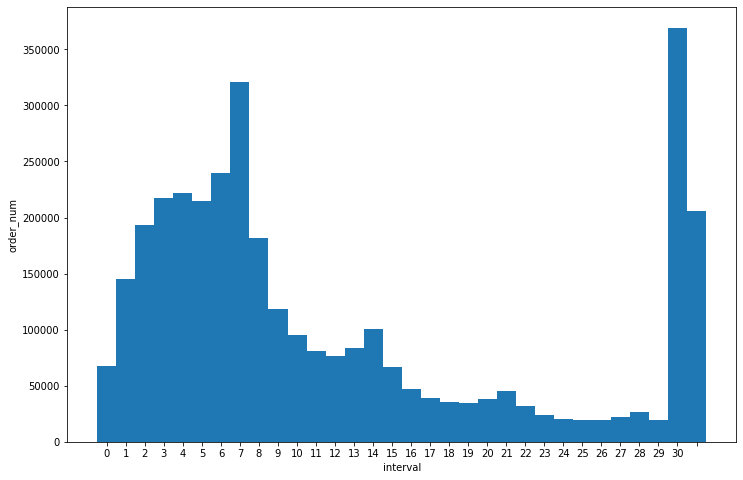

In [70]:
plt.figure(figsize=(12, 8))
plt.xlabel('interval')
plt.ylabel('order_num')

plt.bar(
    df.interval.astype(str), # int型からstr型にしてカテゴリー変数にする
    df.order_num,
    width=1)
plt.show()

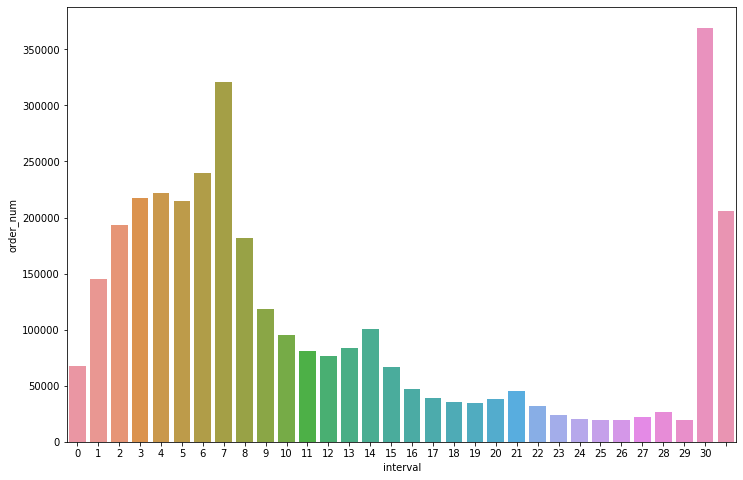

In [64]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='interval', y='order_num')
plt.show()

### Q7. ユーザの利用頻度（副問い合わせ）
顧客の注文回数を集計することで注文回数別の顧客数を求めるSQL文を発行し，その結果を棒グラフで表示せよ．

In [76]:
db = sqlite3.connect(db_path)
sql = """  
    WITH t1 AS (
        SELECT
            user_id,
            MAX(order_number) AS order_num
        FROM
            orders
        GROUP BY
            user_id
    )
    SELECT
        t1.order_num,
        COUNT(user_id) as user_num
    FROM
        t1
    GROUP BY
        t1.order_num
    ORDER BY
        order_num
    ;
"""
df = psql.read_sql(sql, db)
db.close()
df.head()

,order_num,user_num
0,4,23986
1,5,19590
2,6,16165
3,7,13850
4,8,11700


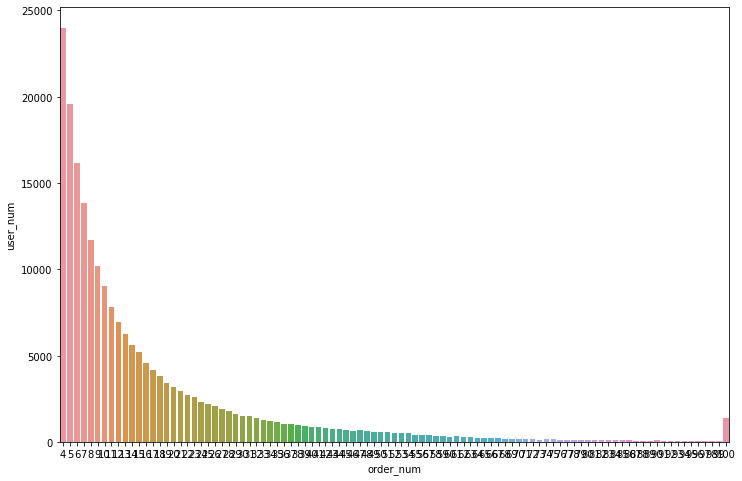

In [77]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x=df.order_num, y=df.user_num)
plt.show()

### Q8. 再注文率（SQL上での算術演算）
商品売り場別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果を表示せよ．なお，結果は再注文率でソートしたものを表示せよ．

In [85]:
db = sqlite3.connect(db_path)
sql = """  
    SELECT
        d.department,
        COUNT(order_id) AS order_num,
        CAST(SUM(reordered) as float) / COUNT(order_id) AS reordered_rate
    FROM
        order_products o
    JOIN
        products p
    USING
        (product_id)
    JOIN
        departments d
    USING
        (department_id)
    GROUP BY
        department_id
    ORDER BY
        reordered_rate DESC
    ;
"""
df = psql.read_sql(sql, db)
db.close()
df.head()

,department,order_num,reordered_rate
0,dairy eggs,5631067,0.670161
1,beverages,2804175,0.653651
2,produce,9888378,0.650521
3,bakery,1225181,0.628381
4,deli,1095540,0.608130


In [86]:
df.tail()

,department,order_num,reordered_rate
16,household,774652,0.403339
17,missing,77396,0.394323
18,international,281155,0.369682
19,pantry,1956819,0.347400
20,personal care,468693,0.321863


### Q9. 商品棚にみる注文回数の分布（Window関数で四分位数を求める）
"pantry"売り場の商品棚別に注文回数の四分位数を求めるSQL文を発行し，その結果をデータフレームに格納し表示せよ．

In [128]:
db = sqlite3.connect(db_path)
sql = """  
    SELECT
        a.aisle,
        p.product_id,
        COUNT(order_id) AS order_num,
        NTILE(4) OVER (PARTITION BY a.aisle_id ORDER BY COUNT(order_id) ASC) AS quartile
    FROM
        order_products op
    JOIN 
        orders o 
    USING
        (order_id)
    JOIN
        products p 
    USING
        (product_id)
    JOIN 
        departments d 
    USING 
        (department_id)
    JOIN 
        aisles a 
    USING 
        (aisle_id)
    WHERE
        d.department == 'pantry' 
    GROUP BY
        p.product_id
    ;
"""
df = psql.read_sql(sql, db)
db.close()
df.head()


,aisle,product_id,order_num,quartile
0,marinades meat preparation,37660,1,1
1,marinades meat preparation,42235,1,1
2,marinades meat preparation,18114,2,1
3,marinades meat preparation,6771,3,1
4,marinades meat preparation,10593,3,1


In [135]:
db = sqlite3.connect(db_path)
sql = """ 
    WITH t1 AS (
        SELECT
            a.aisle,
            p.product_id,
            COUNT(order_id) AS order_num,
            NTILE(4) OVER (PARTITION BY a.aisle_id ORDER BY COUNT(order_id) ASC) AS quartile
        FROM
            order_products op
        JOIN 
            orders o 
        USING
            (order_id)
        JOIN
            products p 
        USING
            (product_id)
        JOIN 
            departments d 
        USING 
            (department_id)
        JOIN 
            aisles a 
        USING 
            (aisle_id)
        WHERE
            d.department == 'pantry' 
        GROUP BY
            p.product_id
    )
    SELECT
        t1.aisle,
        t1.quartile,
        MAX(t1.order_num) AS order_num
    FROM
        t1
    GROUP BY
        t1.aisle,
        t1.quartile
    ;
"""
df = psql.read_sql(sql, db)
db.close()
df.head()


,aisle,quartile,order_num
0,baking ingredients,1,29
1,baking ingredients,2,112
2,baking ingredients,3,449
3,baking ingredients,4,13853
4,baking supplies decor,1,9


In [136]:
df.head(30)

,aisle,quartile,order_num
0,baking ingredients,1,29
1,baking ingredients,2,112
2,baking ingredients,3,449
3,baking ingredients,4,13853
4,baking supplies decor,1,9
5,baking supplies decor,2,20
6,baking supplies decor,3,57
7,baking supplies decor,4,3409
8,condiments,1,17
9,condiments,2,60


### Q10. 商品棚別の注文数および再注文率（リッチな可視化）
商品棚別の商品の注文総数および再注文率を計算するSQL文を発行し，その結果をデータフレームに格納せよ．また，集計結果をもとに，X軸に注文総数（対数スケール），Y軸に再注文率とする散布図を描け．

In [140]:
db = sqlite3.connect(db_path)
sql = """  
    SELECT
        d.department,
        a.aisle,
        COUNT(order_id) AS order_num,
        CAST(SUM(reordered) as float) / COUNT(order_id) AS reordered_rate
    FROM
        order_products op
    JOIN 
        orders o 
    USING
        (order_id)
    JOIN
        products p 
    USING
        (product_id)
    JOIN 
        departments d 
    USING 
        (department_id)
    JOIN 
        aisles a 
    USING 
        (aisle_id)
    GROUP BY
        a.aisle_id
    ;
"""
df = psql.read_sql(sql, db)
db.close()
df.head()

,department,aisle,order_num,reordered_rate
0,deli,prepared soups salads,74864,0.596629
1,dairy eggs,specialty cheeses,86364,0.489753
2,snacks,energy granola bars,473835,0.597995
3,dry goods pasta,instant foods,210604,0.490228
4,pantry,marinades meat preparation,65415,0.281312


In [141]:
df.head(20)

,department,aisle,order_num,reordered_rate
0,deli,prepared soups salads,74864,0.596629
1,dairy eggs,specialty cheeses,86364,0.489753
2,snacks,energy granola bars,473835,0.597995
3,dry goods pasta,instant foods,210604,0.490228
4,pantry,marinades meat preparation,65415,0.281312
5,other,other,38086,0.407052
6,meat seafood,packaged meat,35391,0.542850
7,bakery,bakery desserts,36372,0.499368
8,dry goods pasta,pasta sauce,228123,0.480263
9,household,kitchen supplies,9620,0.194802


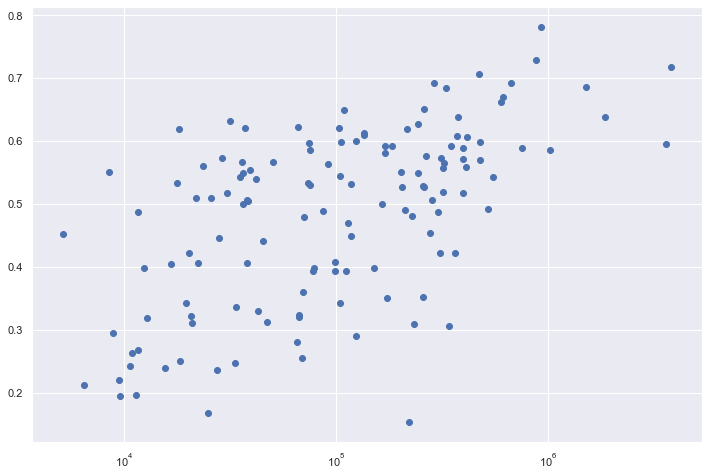

In [155]:
plt.figure(figsize=(12, 8))
plt.scatter(x=df.order_num, y=df.reordered_rate)
#sns.jointplot(x='order_num', y='reordered_rate', data=df)
plt.xscale('log') # x軸を対数表示
plt.show()